# Summary of  LSO Neuron Model

In the following we present a model of LSO neuron with characteristics as seen in vivo experiments in bats and cats.

TODOs 

- Describe the biology of ILD processing and LSO neurons
- Describe the equations and the contributions of each factor
 - Point out what input is missing and how it could contribute to the response
- Create plot of receptive field of a LSO neuron over ILD, ITD (and time?)



TODO from where does the LSO neuron get its inputs (pathways)



1. We present the response of the LSO neuron for varying parameters, especially we investigate whether an subtractive or divisive inhibition contributes for a appropriate shape of response ILD function. The inhibitory inputs play a major role, since they determine the response behavior. Inhibitory inputs can be lateral or from the contralateral ear. (JNBook 0.3,0.4)

2. We investigate the LSO neuron response for different Level modulations. That is, the strenght (level) of contra and ipsilateral input is varied. The repsonse of the LSO neuron varies according to the input level. However the point of complete inhibition stays constant over all level variations (as in  Parker et. al 1997) (JNBook 0.5)

3. Here we incorporated the stimuli delay from the contralateral ear (~200us) and thereby the influence of interaural time difference in our model. We delayed the contral input to the LSO neuron by 200us and showed that with the same parameters as in the previous experiments we can sharpen the ILD response curve (can we?) as shown in Yoris & Yin 1995 (JNBook 0.6)

4. We added inhibitory feedback to the inhibitory and excitatory input of the LSO neuron. We show that if that feedback is turned on the response curve is shifted so that the neuron is tuned more narrowly as in Magnusson et al. 2008 (JNBook 0.7)

5. Here we tuned the inhibitory (GABA) feedback so that the neuron dynamically adaptes to the stimuli history as previously described. With that the response tuning curve adaptes to the stimilu statistics by moving towards the preceeded stimlus as in Magnusson et al 2008 and Lngner et al 2018. Sound localization is not absolute but depends on the stimli history. 

6. Response of neuron to real world input. (16 freq channels etc....)


Stimuli are given at the neurons best frequency and consist of a continous signal (no wave form). 

TODO can we present stimuli that have a frequency? And a correct intensity level in __dB (log scale!)__

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import itertools
plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 20.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'

mpl.rcParams['legend.fontsize'] = 'medium'

mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.titleweight'] = 'heavy'

# print(mpl.rcParams.keys())


In [2]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0


In [3]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.jet,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    # build a threshold. make sure we do not change the original array (called by reference)
    if isinstance(r_bpc, (list,np.ndarray)):
        tmp = 1.0*r_bpc
        tmp[tmp < 0.00] = 0.0
    else:
        if r_bpc < 0.00:
            tmp = 0.0
        else:
            tmp = r_bpc
    
    return 1 / (1 + np.exp(-(tmp-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    q_pc[q_pc < 0.000] = 0.0
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r
    
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    #excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel))  * np.exp(- gaba_exc * g_r_out(r_bpc)) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    #inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) * np.exp(- gaba_inh * g_r_out(r_bpc)) 
    
    
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel))  * 1/(gaba_exc * g_r_out(r_bpc)+1) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) * 1/(gaba_inh * g_r_out(r_bpc)+1) 


            
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    return tau_r * d_r_bpc


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return tau_q * d_q_pc



## Part 1 Parameter Evaluation

### 1.1 LSO Neuron Response for various parameter

The stimulus at the contralateral ear is slowly increasing over time (in steps) to give the neuron membrane time to reach its steady state. The ipsilateral stimulus is held constant

In [3]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))


############################################################
#                       Outputs                            #
############################################################


# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.25

# MNTB inhibitory input (contra-lateral)
gbc_input_onset = 200
gbc_input_duration = 500
gbc_center_frequencyBand = 3
gbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


# build ramps
time_window = 300
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window] = i/(len(t)) * gbc_input_strength
    

    
    

# s_gbc_all[0:400] = 0.0 * gbc_input_strength
# s_gbc_all[400:1600] = 0.25 * gbc_input_strength
# s_gbc_all[1600:2400] = 0.25 * gbc_input_strength
# s_gbc_all[2400:3200] = 0.25* gbc_input_strength
# s_gbc_all[3200:4000] = 1.0 * gbc_input_strength

# LSO direct excitatory input (ipsi-lateral)
sbc_input_onset = 100
sbc_input_duration = 500
sbc_center_frequencyBand = 3
sbc_input_strength = 1.0
sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
# build a plateau at the beginning to let the neurons go to a steady state
s_sbc_all[sbc_input_onset-100:sbc_input_onset] = 1 * sbc_input_strength * sbc_gauss_mask
s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength



# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi





############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:

gammas_r = np.array([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])
kappas_r = np.array([4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0])
gammas_q = np.array([0.0, 0.0, 0.5, 0.0, 1.0, 1.0, 2.0])
kappas_q = np.array([0.0, 0.5, 0.0, 1.0, 0.0, 1.0, 2.0])


q_all = np.zeros((len(gammas_r),len(t),freq_bands))
r_all = np.zeros((len(gammas_r),len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = 0.0

k =0
for gamma_r,kappa_r,gamma_q,kappa_q in zip(gammas_r,kappas_r,gammas_q,kappas_q):
    
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)


            delay_factor = 20
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel,spf_r)       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)

    # increment index
    k+=1






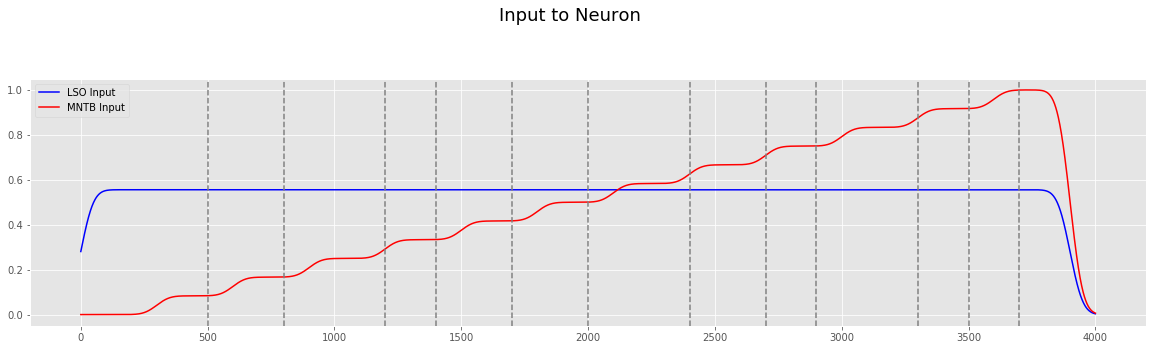

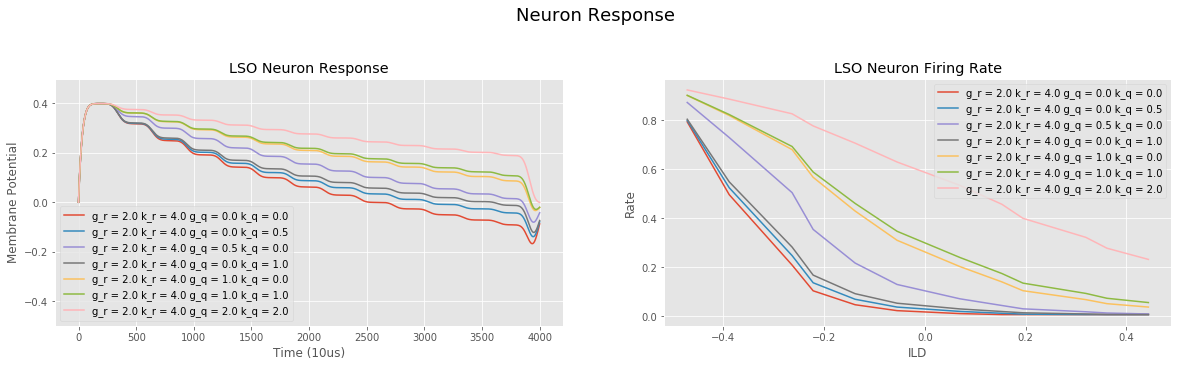

In [4]:
############################################################
#                       Plotting                           #
############################################################
probing_times = [500,800,1200,1400,1700,2000,2400,2700,2900,3300,3500,3700]

fig = plt.figure(figsize=(20,10))
plt.suptitle('Input to Neuron',fontsize=18)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.legend()



# ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
# plt.plot(q_all[i,:,3],'red',  label='MNTB Response')
# plt.plot(r_all[i,:,3],'blue', label='LSO Response')
# plt.title('Membrane Potential')
# plt.ylim([0,1])
# plt.legend()

    





fig = plt.figure(figsize=(20,10))
    # show LSO neuron membrane
plt.suptitle('Neuron Response',fontsize=18)

ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(len(gammas_q)):
    stri = 'g_r = '+str(gammas_r[i])+' k_r = '+str(kappas_r[i])+' g_q = '+str(gammas_q[i])+' k_q = '+str(kappas_q[i])
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,3]
    r = r_all[i,:,3]
    plt.plot(r,label=stri)
plt.title('LSO Neuron Response')
plt.xlabel('Time (10us)')
plt.ylabel('Membrane Potential')
plt.ylim([-0.5,0.5])
plt.legend()


ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
for i in range(len(gammas_q)):
    stri = 'g_r = '+str(gammas_r[i])+' k_r = '+str(kappas_r[i])+' g_q = '+str(gammas_q[i])+' k_q = '+str(kappas_q[i])
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,3]
    r = r_all[i,:,3]
    plt.plot(diff_input[probing_times],g_r_out(r[probing_times]),label=stri)
plt.title('LSO Neuron Firing Rate')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()


plt.show()



### 1.2 LSO Neuron Response for various parameter and realistic change of input level

In natural environments the increase (decrease) of the excitatory input correlates with a corresponding decrease (increase) of the inhibitory input. 

Here we show the response of the neuron for that



In [5]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))


############################################################
#                       Outputs                            #
############################################################


# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.25

# MNTB inhibitory input (contra-lateral)
gbc_input_onset = 200
gbc_input_duration = 500
gbc_center_frequencyBand = 3
gbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


# build ramps
time_window = 200
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window] = i/(len(t)) * gbc_input_strength

# LSO direct excitatory input (ipsi-lateral)
sbc_input_onset = 200
sbc_input_duration = 500
sbc_center_frequencyBand = 3
sbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_sbc_all[-300:-100] =  sbc_input_strength * sbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_sbc_all[sbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
sbc_gauss_mask = sbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_sbc_all[sbc_input_onset:-300] =  sbc_gauss_mask.dot(dec_func).T * sbc_input_strength

# build ramps
time_window = 200
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window] = (len(t)-i)/(len(t)) * sbc_input_strength



# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi





############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:

gammas_r = np.array([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])
kappas_r = np.array([4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0])
gammas_q = np.array([0.0, 0.0, 0.5, 0.0, 1.0, 1.0, 2.0])
kappas_q = np.array([0.0, 0.5, 0.0, 1.0, 0.0, 1.0, 2.0])


q_all = np.zeros((len(gammas_r),len(t),freq_bands))
r_all = np.zeros((len(gammas_r),len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = 0.0

k =0
for gamma_r,kappa_r,gamma_q,kappa_q in zip(gammas_r,kappas_r,gammas_q,kappas_q):
    
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)


            delay_factor = 20
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel,spf_r)       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)

    # increment index
    k+=1






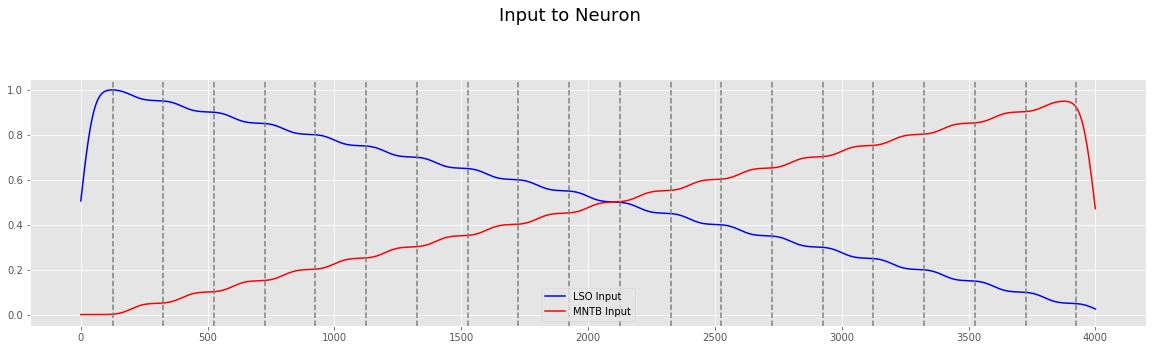

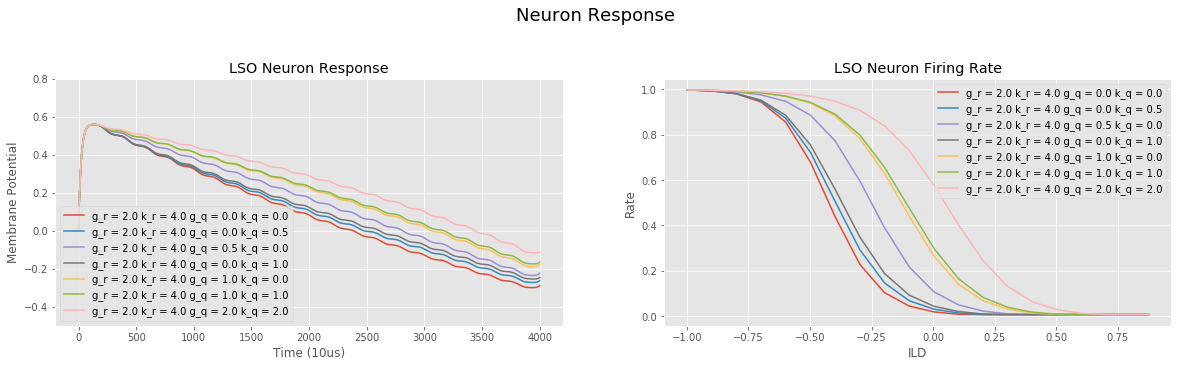

In [6]:
############################################################
#                       Plotting                           #
############################################################
probing_times = np.arange(125,len(t),200)

fig = plt.figure(figsize=(20,10))
plt.suptitle('Input to Neuron',fontsize=18)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.legend()



# ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
# plt.plot(q_all[i,:,3],'red',  label='MNTB Response')
# plt.plot(r_all[i,:,3],'blue', label='LSO Response')
# plt.title('Membrane Potential')
# plt.ylim([0,1])
# plt.legend()

    





fig = plt.figure(figsize=(20,10))
    # show LSO neuron membrane
plt.suptitle('Neuron Response',fontsize=18)

ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(len(gammas_q)):
    stri = 'g_r = '+str(gammas_r[i])+' k_r = '+str(kappas_r[i])+' g_q = '+str(gammas_q[i])+' k_q = '+str(kappas_q[i])
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,3]
    r = r_all[i,:,3]
    plt.plot(r,label=stri)
plt.title('LSO Neuron Response')
plt.xlabel('Time (10us)')
plt.ylabel('Membrane Potential')
plt.ylim([-0.5,0.8])
plt.legend()


ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
for i in range(len(gammas_q)):
    stri = 'g_r = '+str(gammas_r[i])+' k_r = '+str(kappas_r[i])+' g_q = '+str(gammas_q[i])+' k_q = '+str(kappas_q[i])
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,3]
    r = r_all[i,:,3]
    plt.plot(diff_input[probing_times],g_r_out(r[probing_times]),label=stri)
plt.title('LSO Neuron Firing Rate')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()


plt.show()



### LSO Neuron Response for various Spontaneous Firing Rates

The stimulus at the contralateral ear is slowly increasing over time (in steps) to give the neuron membrane time to reach its steady state. The ipsilateral stimulus is held constant

In [7]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))


############################################################
#                       Outputs                            #
############################################################


# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.25

# MNTB inhibitory input (contra-lateral)
gbc_input_onset = 200
gbc_input_duration = 500
gbc_center_frequencyBand = 3
gbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


# build ramps
time_window = 300
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window] = i/(len(t)) * gbc_input_strength
    

    
    

# s_gbc_all[0:400] = 0.0 * gbc_input_strength
# s_gbc_all[400:1600] = 0.25 * gbc_input_strength
# s_gbc_all[1600:2400] = 0.25 * gbc_input_strength
# s_gbc_all[2400:3200] = 0.25* gbc_input_strength
# s_gbc_all[3200:4000] = 1.0 * gbc_input_strength

# LSO direct excitatory input (ipsi-lateral)
sbc_input_onset = 100
sbc_input_duration = 500
sbc_center_frequencyBand = 3
sbc_input_strength = 1.0
sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
# build a plateau at the beginning to let the neurons go to a steady state
s_sbc_all[sbc_input_onset-100:sbc_input_onset] = 1 * sbc_input_strength * sbc_gauss_mask
s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength



# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi





############################################################
#                      Simulation                          #
############################################################


gamma_r = 2.0
kappa_r = 4.0
gamma_q = 0.0
kappa_q = 0.0


q_all = np.zeros((len(gammas_r),len(t),freq_bands))
r_all = np.zeros((len(gammas_r),len(t),freq_bands))

# define the spontaneous firing rate of neuron
spfs_r = [0.0,0.25,0.5,0.75,1.0]

for k in range(len(spfs_r)):
    spf_r = spfs_r[k]
    r_all[k,0,:] = spf_r

    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)


            delay_factor = 20
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel,spf_r)       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)

    # increment index






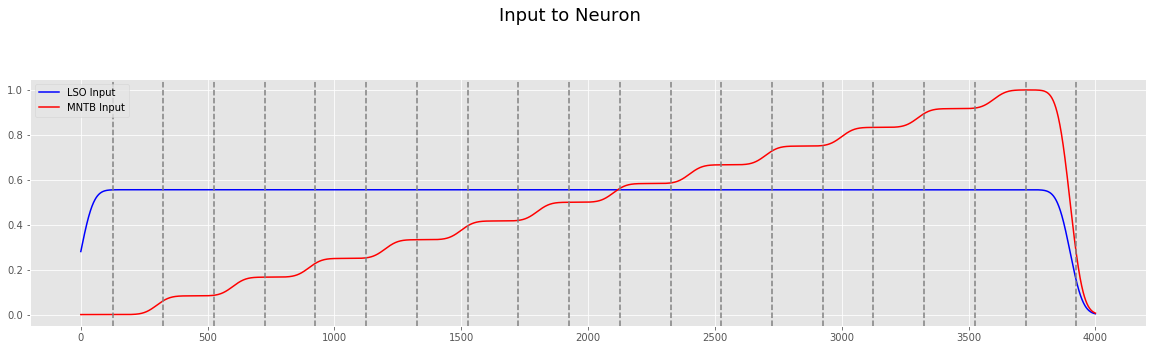

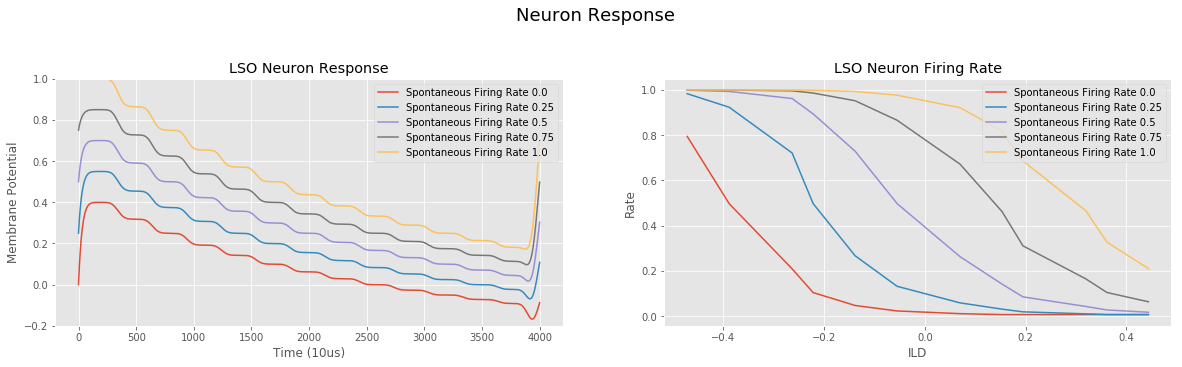

In [8]:
############################################################
#                       Plotting                           #
############################################################

fig = plt.figure(figsize=(20,10))
plt.suptitle('Input to Neuron',fontsize=18)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')

for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.legend()
   


probing_times = [500,800,1200,1400,1700,2000,2400,2700,2900,3300,3500,3700]



fig = plt.figure(figsize=(20,10))
    # show LSO neuron membrane
plt.suptitle('Neuron Response',fontsize=18)

ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(len(spfs_r)):
    stri = 'Spontaneous Firing Rate ' + str(spfs_r[i])
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,3]
    r = r_all[i,:,3]
    plt.plot(r,label=stri)
plt.title('LSO Neuron Response')
plt.xlabel('Time (10us)')
plt.ylabel('Membrane Potential')
plt.ylim([-0.2,1])
plt.legend()


ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
for i in range(len(spfs_r)):
    stri = 'Spontaneous Firing Rate ' + str(spfs_r[i])
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,3]
    r = r_all[i,:,3]
    plt.plot(diff_input[probing_times],g_r_out(r[probing_times]),label=stri)
plt.title('LSO Neuron Firing Rate')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()


plt.show()



## Part 2 Input Level Modulation





### Input Level Modulation on ipsi- and contralateral Ear

Response of LSO neuron is showen for modulated ipsi- and contralateral stimuli level. The modulation takes place for both sides equally.

In [9]:

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [11]:





# Parameter to test
num_input_trials =8

sbc_input_intensities = np.array([0.0,0.07,0.17,0.27,0.37,0.47,0.57,0.87])
gbc_input_intensities = np.array([0.0,0.07,0.17,0.27,0.37,0.47,0.57,0.87])


# store values for different parameters
q_all = np.zeros((num_input_trials,len(t),freq_bands))
r_all = np.zeros((num_input_trials,len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = 0.0
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(0,num_input_trials):
    
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    sigma = 1.25

    # MNTB inhibitory input (contra-lateral)
    gbc_input_onset = 400
    gbc_input_duration = 500
    gbc_center_frequencyBand = 3
    gbc_input_strength = 2.0
    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    gbc_gauss_mask = gauss(np.arange(freq_bands),gbc_center_frequencyBand,sigma)
    # build a plateau at the end to let the neurons go to a steady state
    s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
    # create the decreasing function
    
    
    dec_func = np.zeros((len(t),))
    time_window = 300
    for i in range(0,len(t)-time_window,time_window):
        dec_func[i:i+time_window] = i/(len(t))  
    
    
#     dec_func[0:400] = 0.0
#     dec_func[400:800] = 0.2
#     dec_func[800:1200] = 0.4
#     dec_func[1200:1600] = 0.6
#     dec_func[1600:2000] = 0.8
    
    # add axis so that we acutally have array of (n,m) and not just (n,)
    gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
    dec_func = dec_func[np.newaxis]
    s_gbc_all =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


    # LSO direct excitatory input (ipsi-lateral)
    sbc_input_onset = 0
    sbc_input_duration = 500
    sbc_center_frequencyBand = 3
    sbc_input_strength = 1.0
    sbc_gauss_mask = gauss(np.arange(freq_bands),sbc_center_frequencyBand,sigma)
    s_sbc_all[sbc_input_onset-100:sbc_input_onset] = sbc_input_strength * sbc_gauss_mask
    s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength


    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi



    s_sbc_all *= sbc_input_intensities[k]
    s_gbc_all *= gbc_input_intensities[k]





    
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):
            # E-E kernel
            ee_kernel = gauss(np.arange(freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            delay_factor = 20
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel,spf_r)       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            

#     fig = plt.figure(figsize=(20,15))

#     stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
#     plt.suptitle(stri,fontsize=16)

#     ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
#     plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
#     plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')


# plt.show()


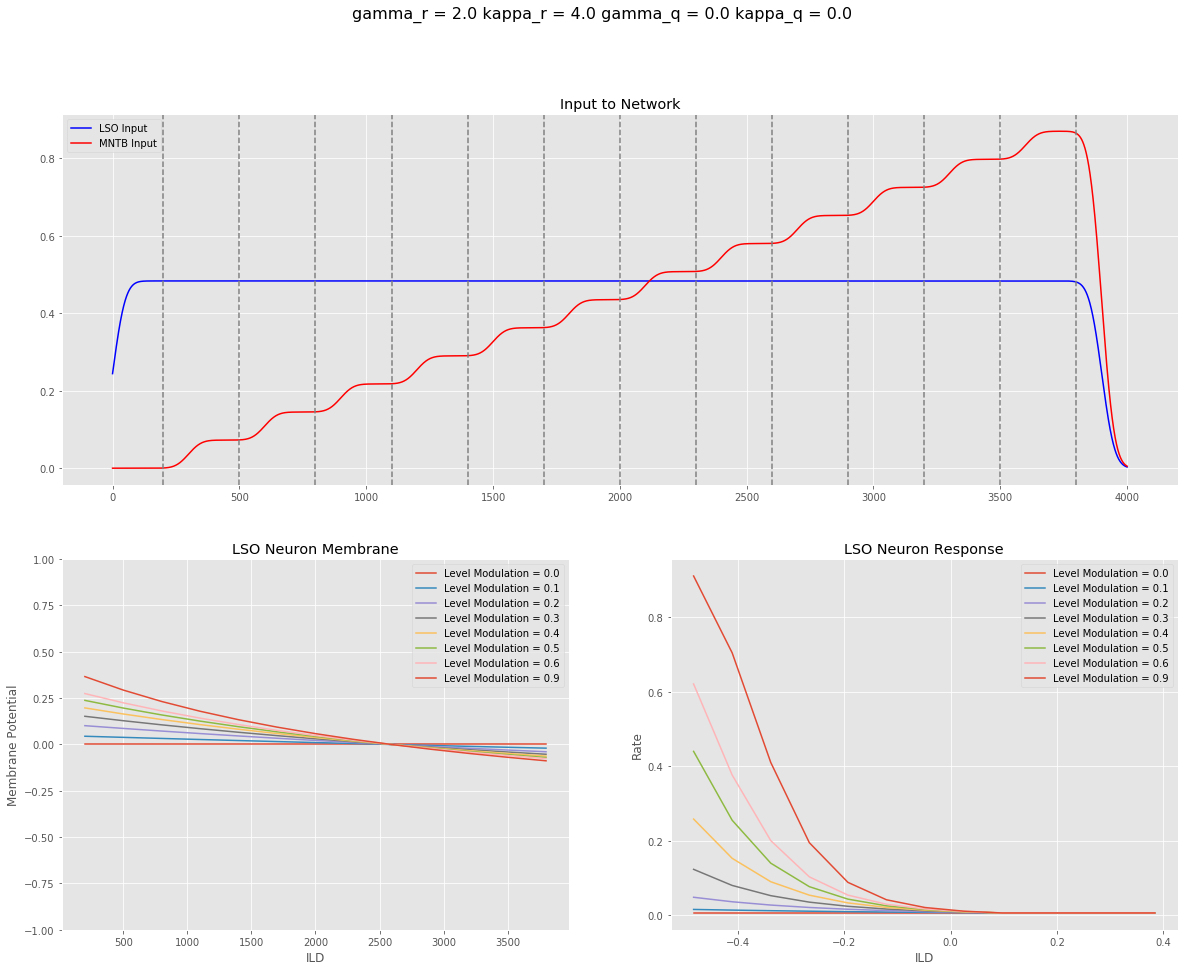

In [14]:

probing_times = [500,800,1100,1400,1700,2000,2300,2600,2900,3200,3500,3800]
probing_times = np.arange(200,len(t),time_window)
# probing_times = [250,750,1150,1500,1800]

fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('Input to Network')
plt.legend()

# ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
# q = q_all[:,:,3]
# for i in range(0,q.shape[0]):
#     plt.plot(probing_times,q[i,probing_times],label='Level Modulation = {0:.1f}'.format(sbc_input_intensities[i]))
# plt.title('MNTB Response')
# plt.legend()

# # show LSO neuron membrane
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(probing_times,r[i,probing_times],label='Level Modulation = {0:.1f}'.format(sbc_input_intensities[i]))

plt.title('LSO Neuron Membrane')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()

diff_input =  s_gbc_all-s_sbc_all
diff_input = diff_input[:,3]
r = r_all[:,:,3]

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input[probing_times],g_r_out(r[i,probing_times]),label='Level Modulation = {0:.1f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()
# plt.ylim([0,1])


plt.show()


### Ipsilateral Excitation (as in Parker et al . 1997)

Contralateral input level is set to 0 and the ipsilaterl input level is increased in 10db steps

In [12]:
# Parameter to test
num_input_trials = 7

sbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57])

# store values for different parameters
q_all = np.zeros((num_input_trials,len(t),freq_bands))
r_all = np.zeros((num_input_trials,len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = 0.0
############################################################
#                      Simulation                          #
############################################################
for k in range(num_input_trials):
    
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    
    # sigma for gauss over frequency bands
    sigma = 1.25

    # MNTB inhibitory input (contra-lateral)
#     gbc_input_onset = 200
#     gbc_input_duration = 500
#     gbc_center_frequencyBand = 3
#     gbc_input_strength = 2.0
#     # create a linearly decreasing function in frequency band 'center_frequencyband'
#     # and smear it with a gauss to effect the neighboring bands
#     gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
#     # build a plateau at the end to let the neurons go to a steady state
#     s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
#     # create the decreasing function
#     dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
#     # add axis so that we acutally have array of (n,m) and not just (n,)
#     gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
#     dec_func = dec_func[np.newaxis]
#     s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


    # LSO direct excitatory input (ipsi-lateral)
    sbc_input_onset = 500
    sbc_input_duration = 500
    sbc_center_frequencyBand = 3
    sbc_input_strength = 1.0
    sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
    # build a plateau at the beginning to let the neurons go to a steady state
    s_sbc_all[sbc_input_onset-100:sbc_input_onset] = sbc_input_strength * sbc_gauss_mask
    # build a plateau at the end to let the neurons go to a steady state
    s_sbc_all[sbc_input_onset:-500] = sbc_gauss_mask * sbc_input_strength


    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    # normalize 
    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi


    s_sbc_all *= sbc_input_intensities[k]

    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):
            # E-E kernel
            ee_kernel = gauss(np.arange(freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            delay_factor = 20
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel,spf_r)       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            







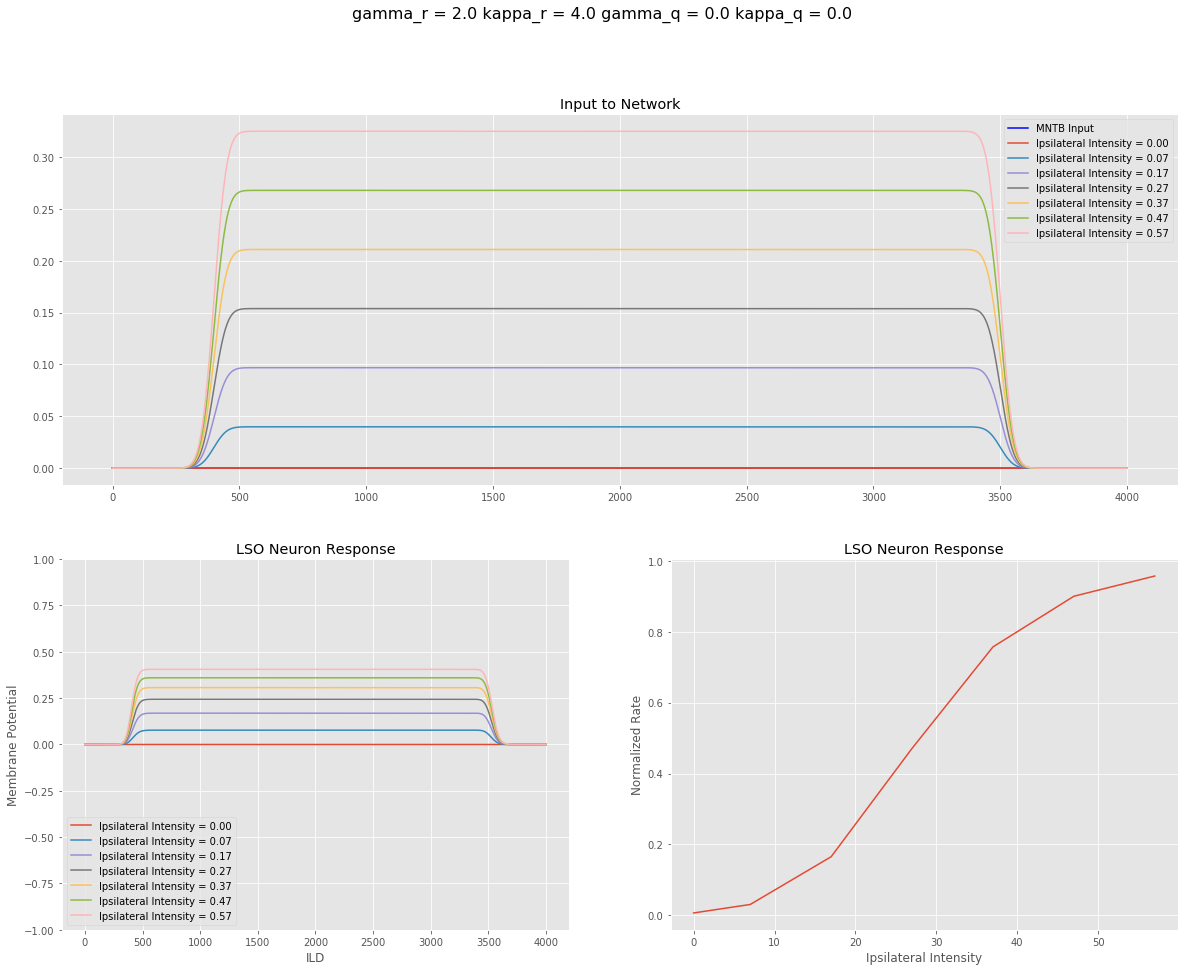

In [13]:
fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.plot(s_gbc_all[:,3], 'blue',  label='MNTB Input')
for i in range(len(sbc_input_intensities)):
    plt.plot(s_sbc_all[:,3]*sbc_input_intensities[i], label='Ipsilateral Intensity = {0:.2f}'.format(sbc_input_intensities[i]))

plt.title('Input to Network')
plt.legend()

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all

diff_input = diff_input[:,3]
r = r_all[:,:,3]
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(r[i,:],label='Ipsilateral Intensity = {0:.2f}'.format(sbc_input_intensities[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)

plt.plot((sbc_input_intensities*100),g_r_out(r[:,800]))


# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('Ipsilateral Intensity')
plt.ylabel('Normalized Rate')
# plt.ylim([0,1])


plt.show()



### Contralateral Inhibition (as in Parker et al. 1997)

For each of the ipsilateral input levels tested previously we present different contralaterl input levels and plot the response. As in the paper of Parker et al. we expect that the point of complete inhibition stays the same no matter what the input level modulation is.

In [14]:




# Parameter to test
num_input_trials = 7
gbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57])
sbc_input_intensities = np.array([ 0.17,0.27,0.37,0.47,0.57])

# store values for different parameters
q_all = np.zeros((len(sbc_input_intensities),num_input_trials,len(t),freq_bands))
r_all = np.zeros((len(sbc_input_intensities),num_input_trials,len(t),freq_bands))


# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,:,0,:] = 0.0
############################################################
#                      Simulation                          #
############################################################
for l in range(len(sbc_input_intensities)):
    for k in range(num_input_trials):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)

        # sigma for gauss over frequency bands
        sigma = 1.25

        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 500
        gbc_input_duration = 500
        gbc_center_frequencyBand = 3
        gbc_input_strength = 1.0
        gbc_gauss_mask = gauss(np.arange(freq_bands),gbc_center_frequencyBand,sigma)
        # build a plateau at the beginning to let the neurons go to a steady state
        s_gbc_all[gbc_input_onset-100:gbc_input_onset] = gbc_input_strength * gbc_gauss_mask
        # build a plateau at the end to let the neurons go to a steady state
        s_gbc_all[gbc_input_onset:-500] = gbc_gauss_mask * gbc_input_strength


        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 500
        sbc_input_duration = 500
        sbc_center_frequencyBand = 3
        sbc_input_strength = 1.0
        sbc_gauss_mask = gauss(np.arange(freq_bands),sbc_center_frequencyBand,sigma)
        # build a plateau at the beginning to let the neurons go to a steady state
        s_sbc_all[sbc_input_onset-100:sbc_input_onset] = sbc_input_strength * sbc_gauss_mask
        # build a plateau at the end to let the neurons go to a steady state
        s_sbc_all[sbc_input_onset:-500] = sbc_gauss_mask * sbc_input_strength


        # Convolve with gauss curve to build a temporal ramp
        s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

        # normalize 
        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
        s_gbc_all /= maxi
        s_sbc_all /= maxi


        s_sbc_all *= sbc_input_intensities[l]
        s_gbc_all *= gbc_input_intensities[k]






        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)
                
                
                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r)       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i,:],ei_kernel,spf_r)       
                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)








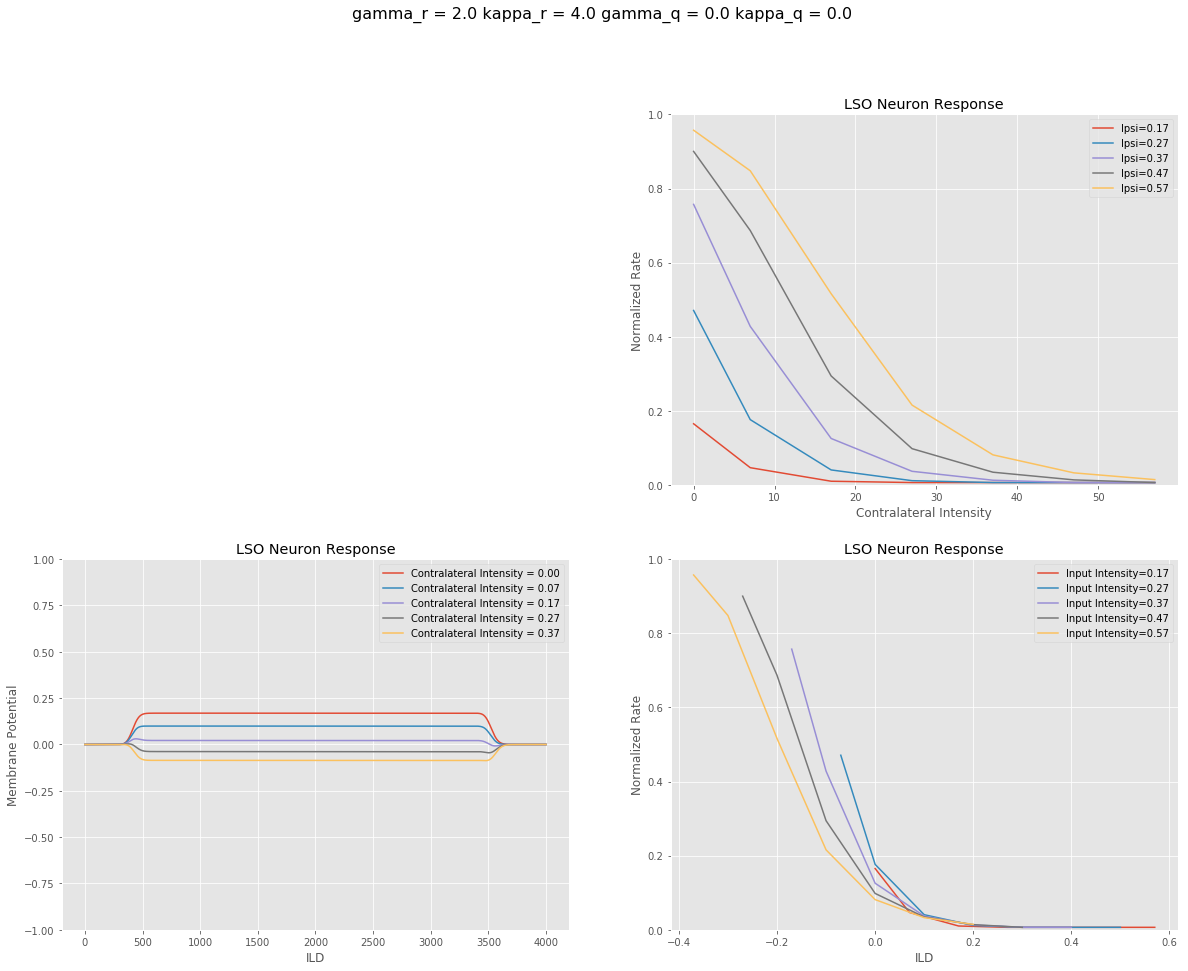

In [15]:
fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# plt.plot(s_sbc_all[:,8],'blue',  label='LSO Input')
# plt.plot(s_gbc_all[:,8],'red',  label='MNTB Input')
# plt.title('Input to Network')
# plt.legend()


# q = q_all[:,:,3]
# ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(q[i,:],label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
# plt.title('MNTB Neuron Response')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])
# plt.legend()

# ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(g_q_out(q[i,:]),label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
# plt.title('MNTB Neuron Response')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])
# plt.legend()



# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all

diff_input = diff_input[:,3]
r = r_all[:,:,:,3]
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(r[0,i,:],label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()
## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
for i in range(len(sbc_input_intensities)):
    plt.plot((gbc_input_intensities*100),g_r_out(r[i,:,800]),label='Ipsi={0:.2f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('Contralateral Intensity')
plt.ylabel('Normalized Rate')
plt.ylim([0,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
for i in range(len(sbc_input_intensities)):
    plt.plot((gbc_input_intensities-gbc_input_intensities[i]),g_r_out(r[i,:,800]),label='Input Intensity={0:.2f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Normalized Rate')
plt.ylim([0,1])
plt.legend()


plt.show()



## Part 3 LSO Response to Interaural Time Delay

We demonstrate how the response curve of a LSO neuron is sharpened by naturally occuring time delays between the excitatory ipsilaterl and inhibitory contralaterl input. As shown in  Grothe 2003

The response of a LSO Neuron for different input intensities is shown. The response is plotted over different time delays of the excitatory and inhibitory stimuli or the so called ITD. 

__TODO__ explain what is happening

In [16]:
gbc_offsets = np.array(np.arange(-100,200,10))
#gbc_input_intensities = np.array([1.0,2.5,5.0,7.5,10.0])
# sbc_input_intensities = np.array([0.5])
# gbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57])
gbc_input_intensities = np.linspace(0,1,20)
sbc_input_intensities = np.linspace(1,0,20)


# store the solutions
q_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))

for l in range(len(gbc_offsets)):
    for k in range(len(gbc_input_intensities)):



        ############################################################
        #                       Inputs                             #
        ############################################################
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 30.0

        
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))
        
        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 200
        gbc_input_duration = 200
        gbc_input_offset = gbc_offsets[l]
        gbc_center_frequencyBand = 3
        gbc_input_strength = gbc_input_intensities[k]
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.arange(gbc_input_duration),gbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state


        s_gbc_all[gbc_input_onset+gbc_input_offset:gbc_input_onset+gbc_input_offset+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
        s_gbc_all[gbc_input_onset+gbc_input_offset+200:gbc_input_onset+gbc_input_offset+200+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
        s_gbc_all[gbc_input_onset+gbc_input_offset+400:gbc_input_onset+gbc_input_offset+400+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
#         s_gbc_all[gbc_input_onset+gbc_input_offset-200:gbc_input_onset+gbc_input_offset-200+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask

        sigma_neighbor = 1.0
        gbc_gauss_mask = gauss(np.arange(freq_bands),gbc_center_frequencyBand,sigma_neighbor)



        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 200
        sbc_input_duration = 200
        sbc_input_offset = 0
        sbc_center_frequencyBand = 3
        sbc_input_strength = sbc_input_intensities[k]

        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.arange(sbc_input_duration),sbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state


#         s_sbc_all[sbc_input_onset+sbc_input_offset:sbc_input_onset+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
        s_sbc_all[sbc_input_onset+200+sbc_input_offset:sbc_input_onset+200+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
#         s_sbc_all[sbc_input_onset+400+sbc_input_offset:sbc_input_onset+400+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
#         s_sbc_all[sbc_input_onset-200+sbc_input_offset:sbc_input_onset-200+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask

        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
#         s_gbc_all /= maxi
#         s_sbc_all /= maxi



        ############################################################
        #                      Simulation                          #
        ############################################################



        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                delay_factor = 20
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r)       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r)       
                
                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)



        # remove delay input from MNTB
        #s_gbc_all = np.roll(s_gbc_all,-delay_factor,axis=0)

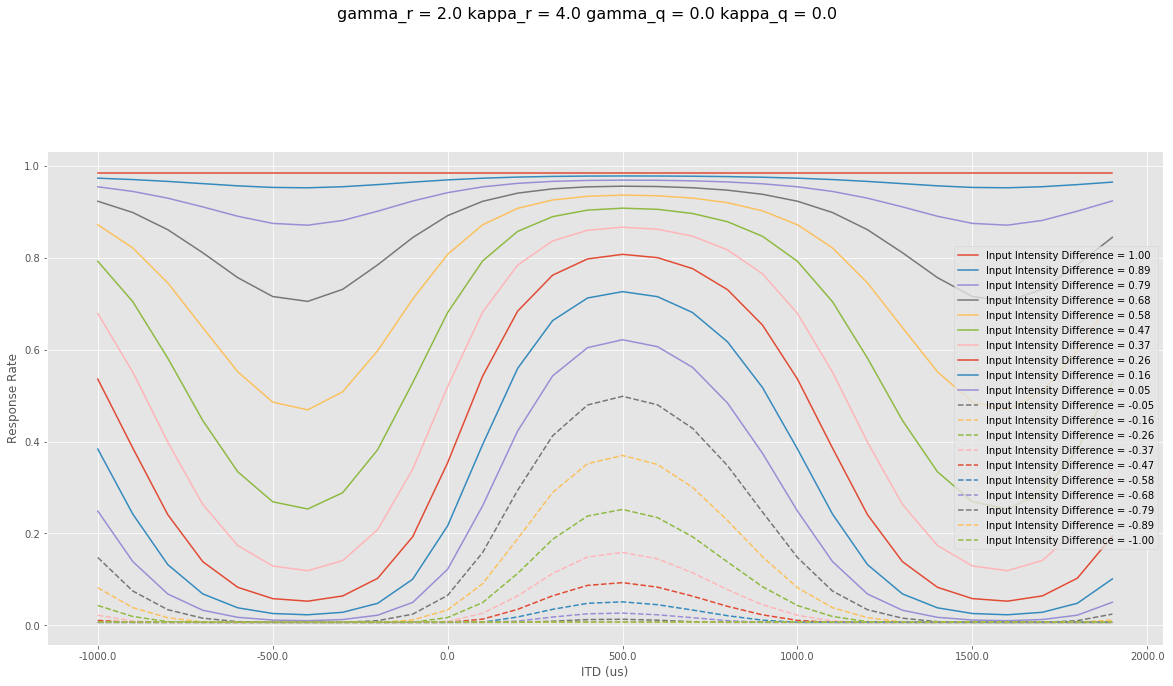

In [17]:
fig = plt.figure(figsize=(20,20))
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

r = g_r_out(r_all[:,:,:,3])
q = q_all[:,:,:,3]

ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=2)
for i in range(r.shape[1]):
    level_diff = sbc_input_intensities[i] - gbc_input_intensities[i]
    if level_diff < 0:
        line_style = '--'
    else:
        line_style = '-'
    ax1.plot(gbc_offsets[:],r[:,i,500],linestyle = line_style,label='Input Intensity Difference = {0:.2f}'.format(level_diff))

plt.xlabel('ITD (us)')
plt.ylabel('Response Rate')
ax1.set_xticklabels(ax1.get_xticks()*10)
plt.legend()
plt.show()


These results are in line with the findings of Beiderbeck et al. 2018 in where they say that an increase in spiking rate could be obeserved when inhibition is leading excitation by around 400-600us. However in their in vitro and in vivo experiments they also consider the time delay of inputs based on their level (1ms/10dB). 

Our simulated neuron also has increases firing rate for ~500us. Is that by conincidence or can we explain the findings form Beiderbeck et. al with our model?

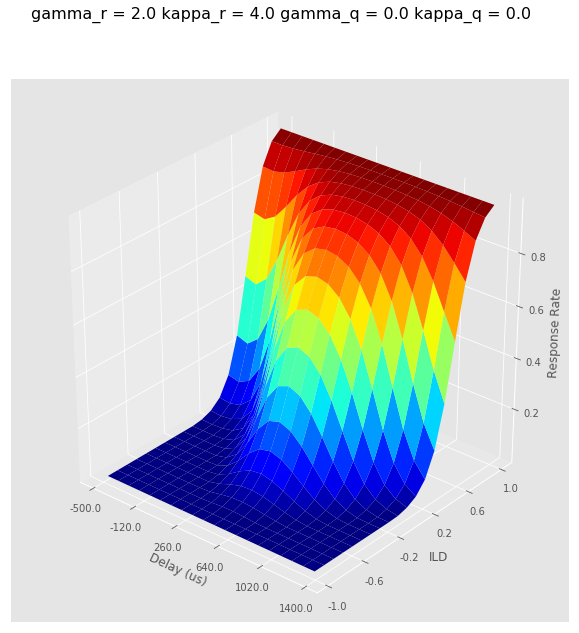

In [18]:
# fig = plt.figure(figsize=(20,20))
# ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=2)
# plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
# plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
# plt.title('Input to Network')
# plt.legend()


fig = plt.figure(figsize=(10,10))
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

r = g_r_out(r_all[:,:,:,3])
q = q_all[:,:,:,3]


ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=2,projection='3d')
mesh_plot(r[5:25,:,500],ax1)
ax1.view_init(elev=30., azim=-50)
plt.ylabel('ILD')
plt.xlabel('Delay (us)')
ax1.set_zlabel('Response Rate')
# ax1.set_xticklabels(gbc_offsets[5:25:5])
ild_ticks = gbc_input_intensities-sbc_input_intensities
ild_ticks = np.linspace(np.min(ild_ticks),np.max(ild_ticks),len(ax1.get_yticks())-2)
ax1.set_yticklabels(['{0:.1f}'.format(-i) for i in ild_ticks])

itd_ticks = gbc_offsets[5:25]
itd_ticks = np.linspace(np.min(itd_ticks),np.max(itd_ticks),len(ax1.get_xticks())-2)
ax1.set_xticklabels(['{0:.1f}'.format(i*10) for i in itd_ticks])
plt.gca().invert_yaxis()

plt.show()






Here we plot the LSO response for various time delays for an input level difference of __zero__

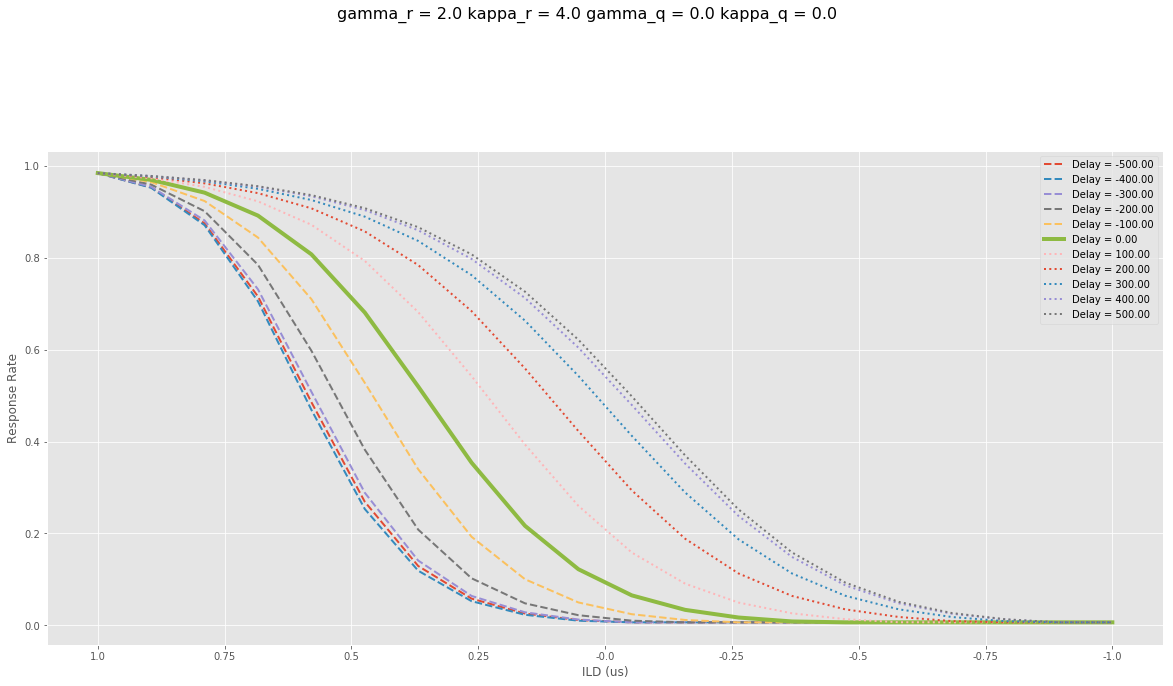

In [19]:
fig = plt.figure(figsize=(20,20))
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

r = g_r_out(r_all[:,:,:,3])
q = q_all[:,:,:,3]
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=2)
for i in range(5,r.shape[0]-14):
    
    if gbc_offsets[i] < 0:
        line_style = '--'
        line_width = 2
    elif gbc_offsets[i] == 0:
        line_style = '-'
        line_width = 4
    else:
        line_style = ':'
        line_width = 2
    ax1.plot((gbc_input_intensities-sbc_input_intensities),r[i,:,500],linewidth=line_width,linestyle=line_style,label='Delay = {0:.2f}'.format(gbc_offsets[i]*10))

ax1.set_xticklabels(ax1.get_xticks()*-1)
plt.xlabel('ILD (us)')
plt.ylabel('Response Rate')
plt.legend()
plt.show()

Effectiveness of the inhibitory signal decreases when it is shifted in time. See Park et al. 1995
Point of complete inhibition should be shifted with a shift of inhibitory signal timing

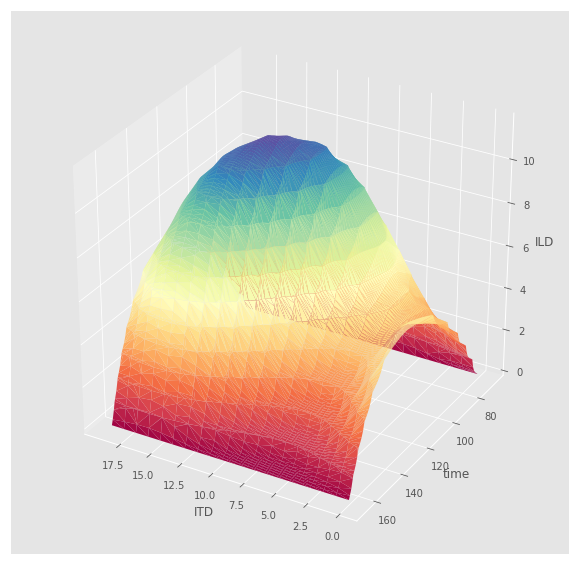

In [20]:
r = g_r_out(r_all[:,:,:,:])

vol =g_r_out(r[5:25,0:,400:600,3])
# vol =np.transpose(g_r_out(r[:,:,:,3]),[2,1,0])

verts = None
faces = None
verts, faces = measure.marching_cubes_classic(vol, spacing=(1.0, 1.0, 1.0),level=0.9,gradient_direction='descent')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    verts[:, 0], verts[:, 2], faces, verts[:, 1], cmap='Spectral', lw=0.0)
ax.view_init(elev=30., azim=120)

ax.set_ylabel('time')
ax.set_xlabel('ITD')
ax.set_zlabel('ILD')
plt.show()

## Part 4 LSO Response with inhibitory feedback on the excitatory and inhibitory input

 We added inhibitory feedback on the inhibitory and excitatory input of the LSO neuron. We show that if that feedback is turned on the response curve is shifted so that the neuron is tuned more narrowly as in Magnusson et al. 2008 (JNBook 0.7). The feedback modulates with 1/x 

The response curce shift to the right side of the ILD range works only if we present the stimuli long enough. It seems that the membrane dynamics are slower now?

In [21]:

# GABA parameter
gaba_inh = np.linspace(0,17,17)
gaba_exc = np.linspace(0,17,17)

# GABA parameter
# gaba_exc = np.array([2,6,10,14,16,18,20,22])
# gaba_inh = np.arange(0,18.5,5.0)

# store values for different parameters
q_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))
r_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))



sbc_input_intensities = np.array([1.0])
gbc_input_intensities = np.array([1.0])


# store values for different parameters
q_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))
r_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))


# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,:,0,:] = spf_r
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(len(gaba_exc)):

    l = k 
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    sigma = 1.25

    # MNTB inhibitory input (contra-lateral)
    gbc_input_onset = 300
    gbc_input_duration = 500
    gbc_center_frequencyBand = 3
    gbc_input_strength = 2.0
    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
    # build a plateau at the end to let the neurons go to a steady state
    s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
    # create the decreasing function
    dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
    # add axis so that we acutally have array of (n,m) and not just (n,)
    gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
    dec_func = dec_func[np.newaxis]
    s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


    # build ramps
    time_window = 300
    for i in range(0,len(t)-time_window,time_window):
        s_gbc_all[i:i+time_window] = i/(len(t)) * gbc_input_strength

    # LSO direct excitatory input (ipsi-lateral)
    sbc_input_onset = 100
    sbc_input_duration = 500
    sbc_center_frequencyBand = 3
    sbc_input_strength = 2.0
    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
    # build a plateau at the end to let the neurons go to a steady state
    s_sbc_all[-300:-100] =  sbc_input_strength * sbc_gauss_mask
    # create the decreasing function
    dec_func = np.linspace(0,1,len(s_sbc_all[sbc_input_onset:-300]))
    # add axis so that we acutally have array of (n,m) and not just (n,)
    sbc_gauss_mask = sbc_gauss_mask[np.newaxis].T
    dec_func = dec_func[np.newaxis]
    s_sbc_all[sbc_input_onset:-300] =  sbc_gauss_mask.dot(dec_func).T * sbc_input_strength

    # build ramps
    time_window = 300
    for i in range(0,len(t)-time_window,time_window):
        s_sbc_all[i:i+time_window] = (len(t)-i)/(len(t)) * sbc_input_strength



    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi

    s_sbc_all *= sbc_input_intensities[0]
    s_gbc_all *= gbc_input_intensities[0]

    for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r,gaba_exc[l],gaba_inh[k])       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc[l],gaba_inh[k])       

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)





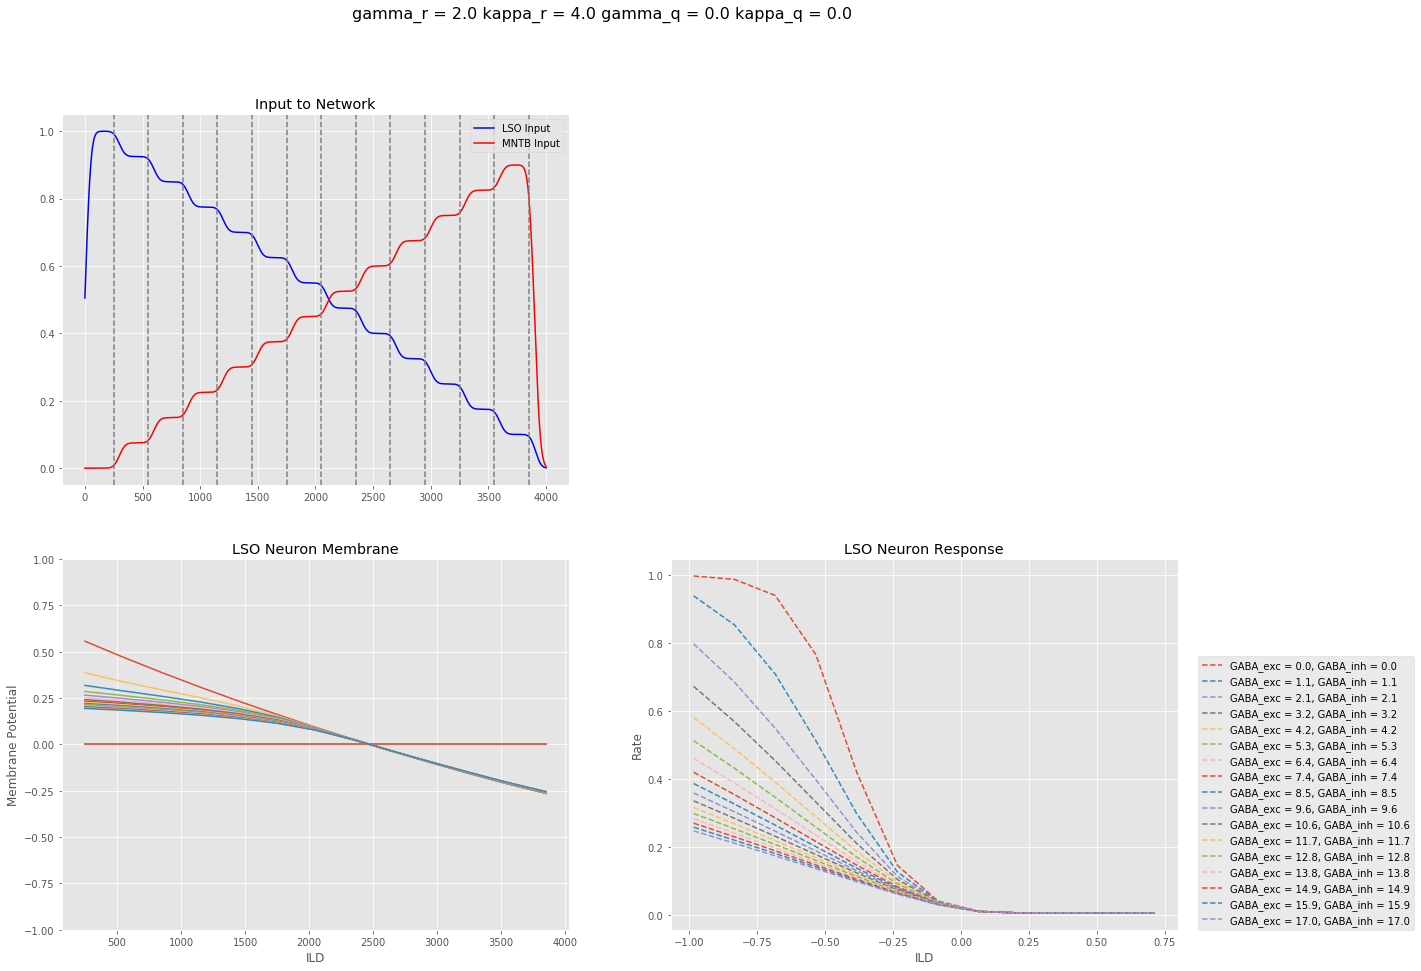

In [22]:
# Define the times when to probe
probing_times = [300,700,1100,1500,1900,2300,2700,3100,3500]
probing_times = np.arange(250,len(t),300)


fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('Input to Network')
plt.legend()

# show LSO neuron membrane
diff_input =  s_gbc_all-s_sbc_all
diff_input = diff_input[:,3]
r = r_all[:,:,:,3]
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    for j in range(0,r.shape[1]):
        plt.plot(probing_times,r[i,j,probing_times])
plt.title('LSO Neuron Membrane')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
for i in range(0,r.shape[0]):
    j = i
    plt.plot(diff_input[probing_times],g_r_out(r[i,j,probing_times],a=20),linestyle='--',label='GABA_exc = {0:.1f}, GABA_inh = {1:.1f}'.format(gaba_exc[i],gaba_inh[j]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
# plt.ylim([0,1])
plt.legend(loc=(1.04,0))

plt.show()




In [23]:
%matplotlib qt

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# a = g_r_out(r[:,:,probing_times])   

# fig = plt.figure(figsize=(20,15))
# ax1 = fig.add_subplot(111, projection='3d')

# for i in range(a.shape[0]):
#     mesh_plot(a[i,:,:],ax1)
    
# plt.show()

In [ ]:
%matplotlib inline